In [24]:
! python -m pip install scipy

     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     ------------ ------------------------- 20.5/60.4 kB 682.7 kB/s eta 0:00:01
     ------------ ------------------------- 20.5/60.4 kB 682.7 kB/s eta 0:00:01
     ------------------- ------------------ 30.7/60.4 kB 187.9 kB/s eta 0:00:01
     ------------------- ------------------ 30.7/60.4 kB 187.9 kB/s eta 0:00:01
     ------------------------- ------------ 41.0/60.4 kB 151.3 kB/s eta 0:00:01
     -------------------------------------- 60.4/60.4 kB 214.5 kB/s eta 0:00:00
   ---------------------------------------- 0.0/45.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/45.8 MB 2.8 MB/s eta 0:00:17
   ---------------------------------------- 0.4/45.8 MB 3.7 MB/s eta 0:00:13
   ---------------------------------------- 0.5/45.8 MB 3.6 MB/s eta 0:00:13
    --------------------------------------- 0.7/45.8 MB 4.0 MB/s eta 0:00:12
    --------------------------------------- 0.9/45.8 MB 3.6 MB/s eta 0

In [25]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# Data import

file_path = "C:/Users/tomco/Documents/data/Makespace_Red_TTM20240217.csv"

df = pd.read_csv(file_path)

#print(df)


Data cleaning:
    Make sure first and last entries are 'On' and 'Off' respectively. 
    Remove changes that last for less than 2 seconds (e.g. accidentally turning it on and then off, or power blip maybe) - make the 2 seconds editable

Requested data:

    How many times is each item of Equipment used?
    How long is each item used; length of session ?
    What is the average and distribution of the sessions for each item?
    How many users of each equipment are there?
    Is there any trends over time?  e.g are more people using an item now than last year, or are they using it longer?
    Any equipment which is used together more often than not?

My additions:
    

Output:
    Report
    Figures for presentation


In [110]:
#Checking and tidying data 

# Making sure each tool has a complete cycle of uses - Makes sure first entry is "ON", last entry is "OFF". Also need to identify weird entries.

#Converting to datetime objects
df[['Date/time', 'timestamp']] = df[['Date/time', 'timestamp']].apply(pd.to_datetime)
df['date'] = df['timestamp'].dt.date
df['time'] = df['timestamp'].dt.time
df['action-ID'] = np.arange(len(df))

#Seeing whether we need both Date/time and timestamp:

#difftime_df = df[df['timestamp'].dt.time != df['Date/time'].dt.time]
#print(difftime_df)

#Nope
df.drop('Date/time', axis=1)


#Finding odd values
Where_List = df.Where.unique()
#print(Where_List)
Details_List = df.Details.unique()
#print(Details_List)
User_List = df.User_hash.unique()
#print(len(User_List))

#Strange 'invalid access' entry in 'Details'.
Invalid_entries = df[df['Details'] == 'Invalid access']


# list to populate with rows to be removed, and others to be tracked
remove_list = []

Invalid_entries_list = []

Invalid_Entries_In_Context = []

Double_Entries = []

Double_Entries_In_Context = []

Total_Runtime_dfs = []

#This loops through each tool, finds the first and last entries, and checks them (to make sure first entry is "on", last entry is "off"). Also investigates invalid access and checks that those entries don't disturb the flow. 
# If it turns out the invalid entry is due to it being the first time the machine is turned on, it's assumed this is part of the machine setup process, and is ignored. 
for x in Where_List:
    #print(x)
    Tool_df = df.loc[df['Where'] == x]
    #print(Tool_df)
    if 'Invalid access' in Tool_df.Details.values:
        #print("Invalid Entries found")
        Tool_df.loc[:,'Tool_use_index'] = np.arange(len(Tool_df))[::-1]
        Invalid_entries = Tool_df.loc[Tool_df["Details"] == 'Invalid access']
        remove_list.append(Invalid_entries.index)
        Invalid_entries_list.append(Invalid_entries.index)
        Invalid_use = Invalid_entries.loc[:,'Tool_use_index'].tolist()
        #print(Invalid_use)
        if 0 in Invalid_use:
            print("Invalid use at first operation of ", x, "found and removed")
            Invalid_use.remove(0)

        if len(Invalid_use) > 0:
            Around_Invalid_Use = [
                (x-2, x-1, x, x+1, x+2) 
                for x in Invalid_use
            ]
            Around_Invalid_Use = [
                x
                for xs in Around_Invalid_Use
                for x in xs
            ]
            Around_Invalid_Use_df = Tool_df.loc[Tool_df['Tool_use_index'].isin(Around_Invalid_Use)]
            Invalid_Entries_In_Context.append(Around_Invalid_Use_df.index)

        Activations_status_around_invalid = Around_Invalid_Use_df.iloc[[1, 3], 1].tolist()

            #print(Activations_status_around_invalid)
            
        if not all(["ON" in Activations_status_around_invalid, "OFF" in Activations_status_around_invalid]):
                print("Error - Activations out of sync around invalid change for ", x, ".")
                weird_activation_counts = Around_Invalid_Use_df['Details'].value_counts()
                print(weird_activation_counts)

                if weird_activation_counts.OFF > weird_activation_counts.ON:
                    print("More Off's than On's for ", x, ". Checking if change before and after invalid access is Off - if so, will Delete the Off after the invalid change.")
                    if all([Around_Invalid_Use_df.iloc[1, 1] == 'OFF', Around_Invalid_Use_df.iloc[3, 1] == 'OFF']):
                        print("Activations before and after invalid change for ", x, "are both Off. Removing the change after invalid change.")
                        remove_list.append(Around_Invalid_Use_df.iloc[[1],:].index)
                    else:
                        print("Activations before and after invalid change for ", x, "are not both Off. Please check data manually.")
                        print(Around_Invalid_Use_df)

                if weird_activation_counts.OFF < weird_activation_counts.ON:
                    print("More On's than Off's for ", x, ". Checking if change before invalid access is On - if so, will Delete the On before the invalid change.")
                    if all([Around_Invalid_Use_df.iloc[1, 1] == 'ON', Around_Invalid_Use_df.iloc[3, 1] == 'ON']):
                        print("Activations before and after invalid change for ", x, "are both On. Removing the change before invalid change.")
                        remove_list.append(Around_Invalid_Use_df.iloc[[3],:].index)
                    else:
                        print("Activations before and after invalid change for ", x, "are not both On. Please check data manually.")
                        print(Around_Invalid_Use_df)

                if(weird_activation_counts.OFF == weird_activation_counts.ON):
                    print("Same number of Offs and Ons around invalid change for ", x, "- Please examine manually.")
                    print(Around_Invalid_Use_df)
    
    remove_list_forTool = [
                x
                for xs in remove_list
                for x in xs
            ]
    Tool_df.drop(Tool_df[Tool_df.index.isin(remove_list_forTool)].index, inplace=True)

    #Checking rows alternate between "ON" and "OFF" regularly
    regularity_check = pd.DataFrame(Tool_df.iloc[::2,])
    #print(regularity_check)
    #print(regularity_check.Details.unique())
    #print(len(regularity_check.Details.unique()))
    if len(regularity_check.Details.unique()) > 1:
            
            Tool_df.loc[:,'Tool_use_index'] = np.arange(len(Tool_df))[::-1]

            print("Irregular activations (not On-Off-On-Off...) for ",x, ".")
            detailed_regularity_check = pd.DataFrame(Tool_df)

            detailed_regularity_check.loc[:,"Regularity_Status"] = detailed_regularity_check.loc[:,"Details"].shift() == detailed_regularity_check.loc[:,"Details"]
            #detailed_regularity_check["Regularity_Status"].iloc[0] = False
            detailed_regularity_check.loc[0,'Regularity_Status'] = False

            irregularities = detailed_regularity_check[detailed_regularity_check['Regularity_Status'] != False]
            #print(irregularities)
            irregularity_location = irregularities.loc[:,'Tool_use_index'].tolist()


            if len(irregularity_location) > 0:
                        Around_irregularity_location = [
                            (x-2, x-1, x, x+1, x+2) 
                            for x in irregularity_location
                        ]
                        Around_irregularity_location = [
                            x
                            for xs in Around_irregularity_location
                            for x in xs
                        ]
            Around_irregularity_location_df = detailed_regularity_check.loc[detailed_regularity_check['Tool_use_index'].isin(Around_irregularity_location)]
            Double_Entries_In_Context.append(Around_irregularity_location_df.index)

            #print(Around_irregularity_location_df)
                        
            #################
            #Decision - the irregularities, as they appear in this table, seem to highlight that in most cases (90-95%) the most likely one to be a mistake is the irregularity. 
            #Because the alternative is manual cleaning, I have decided to remove all irregularities, and see what that does to the time on figure.
            #################
            remove_list.append(irregularities.index)
            Double_Entries.append(irregularities.index)
    
    remove_list_forTool = [
                x
                for xs in remove_list
                for x in xs
            ]

    Tool_df.drop(Tool_df[Tool_df.index.isin(remove_list_forTool)].index, inplace=True)


    regularity_check_2 = pd.DataFrame(Tool_df.iloc[::2,])
    #print(len(regularity_check_2.Details.unique()))
    if len(regularity_check_2.Details.unique()) > 1:
            print("Irregular activations (not On-Off-On-Off...) for ",x, " On second pass.")
    

    First_entry = Tool_df.iloc[[-1]]
    if First_entry.Details.any() == "OFF":
        print("First recorded change for ",x, " is turning tool off - recorded change removed.")
        remove_list.append(First_entry.index)

    Last_entry = Tool_df.iloc[[0]]
    if Last_entry.Details.any() == "ON":
        print("Last recorded change for ",x, " is turning tool on - recorded change removed.")
        remove_list.append(Last_entry.index)
    
        remove_list_forTool = [
                x
                for xs in remove_list
                for x in xs
            ]
    Tool_df.drop(Tool_df[Tool_df.index.isin(remove_list_forTool)].index, inplace=True)

    print(Tool_df['Details'].value_counts())


    Tool_df['Next_change'] = Tool_df['timestamp'].shift()
    Tool_RunTime = Tool_df[Tool_df['Details']=="ON"]
    Tool_RunTime['RunTime'] = Tool_RunTime['Next_change'] - Tool_RunTime['timestamp']

    Total_Runtime_dfs.append(Tool_RunTime)
    

Tool_runtimes_df = pd.concat(Total_Runtime_dfs)

Tool_runtimes_df['RunTime'] = Tool_runtimes_df['Next_change'] - Tool_runtimes_df['timestamp']

Tool_runtimes_df.loc[:,'Tool_Runtime_ID'] = np.arange(len(Tool_runtimes_df))

Total_RunTime = Tool_runtimes_df['RunTime'].sum()

 

Irregular activations (not On-Off-On-Off...) for  Metal Lathe .
Details
OFF    96
ON     96
Name: count, dtype: int64
Invalid use at first operation of  Band Saw found and removed
Irregular activations (not On-Off-On-Off...) for  Band Saw .
Details
OFF    688
ON     688
Name: count, dtype: int64
Irregular activations (not On-Off-On-Off...) for  Planer/Thicknesser .
Details
OFF    175
ON     175
Name: count, dtype: int64
Irregular activations (not On-Off-On-Off...) for  Mitre Saw .
Details
OFF    163
ON     163
Name: count, dtype: int64
Irregular activations (not On-Off-On-Off...) for  Laser Cutter (Jaws) .
Details
OFF    1410
ON     1410
Name: count, dtype: int64
Irregular activations (not On-Off-On-Off...) for  Wood Lathe .
Details
OFF    351
ON     351
Name: count, dtype: int64
Irregular activations (not On-Off-On-Off...) for  Metal Mill .
Details
OFF    44
ON     44
Name: count, dtype: int64
Invalid use at first operation of  CNC Router found and removed
Irregular activations (not O

C:\Users\tomco\AppData\Local\Temp\ipykernel_24404\2569044308.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tool_df.drop(Tool_df[Tool_df.index.isin(remove_list_forTool)].index, inplace=True)
C:\Users\tomco\AppData\Local\Temp\ipykernel_24404\2569044308.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tool_df.loc[:,'Tool_use_index'] = np.arange(len(Tool_df))[::-1]
C:\Users\tomco\AppData\Local\Temp\ipykernel_24404\2569044308.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

1        11.183333
5       198.133333
50      173.300000
100       1.450000
102      25.616667
           ...    
8662      9.233333
8665     22.750000
8668      0.216667
8672     85.783333
8674      3.633333
Name: RunTime, Length: 4246, dtype: float64

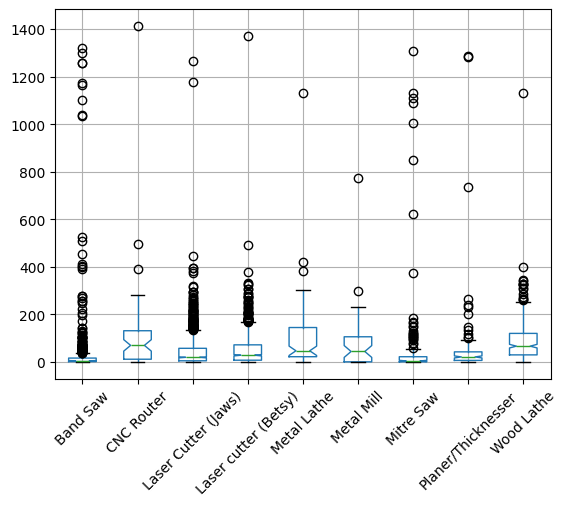

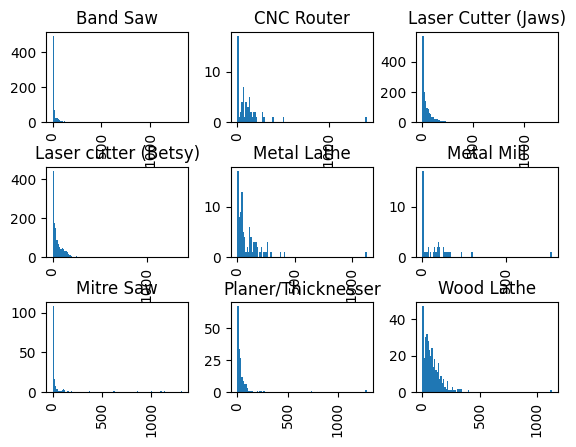

In [154]:
#Data visualisation 1

Tool_runtimes_df['Runtime_Minutes'] = Tool_runtimes_df.loc[:,'RunTime'].dt.seconds/60

Tool_runtimes_stripped = pd.DataFrame(Tool_runtimes_df.loc[:,['Where', 'Runtime_Minutes']])

Tool_usetimes = Tool_runtimes_stripped.pivot(columns = 'Where')['Runtime_Minutes']

Tool_usetimes.boxplot(notch = True, labels = list(Tool_usetimes))

plt.xticks(rotation=45)

#Showing a few of unrealistic outliers. 20+ hours of constant bandsaw use? Suspicious.

Tool_usetimes.describe()

Tool_runtimes_stripped.hist('Runtime_Minutes', by='Where', bins=100)

plt.show()




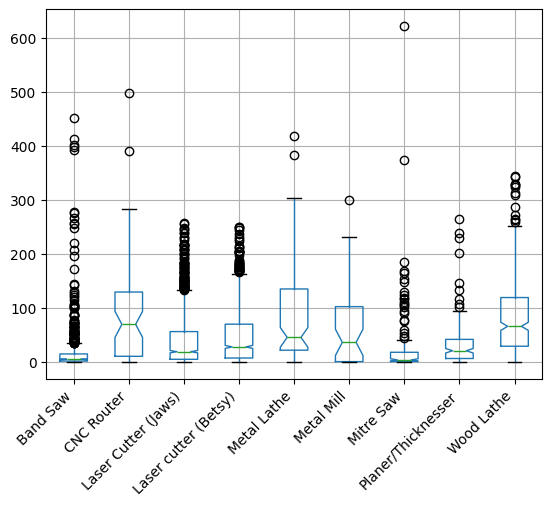

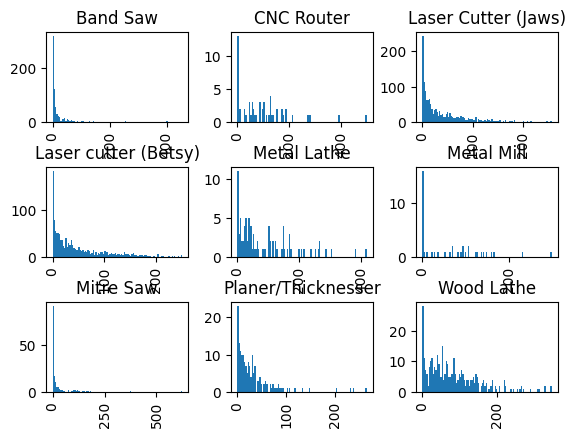

In [155]:
#Data cleaning - removing outliers

#Trying to grab outliers too, so that they can be tracked back to the original entries, to see why they're there.



#np.abs(stats.zscore(Tool_usetimes, nan_policy='omit')) >= 3 #This is showing all the good values (true) and the bad values (false). Most bad values are actual NaN, which are structural. 




Tool_usetimes_2 = Tool_usetimes

Tool_usetimes_2[(np.abs(stats.zscore(Tool_usetimes, nan_policy='omit')) >= 3)] = np.nan

Tool_usetimes_tidied = Tool_usetimes_2.dropna(axis = 0, how = 'all')

Tool_usetimes_tidied.boxplot(notch = True, labels = list(Tool_usetimes_tidied))

plt.xticks(rotation=45, ha='right')

plt.show()

Tool_runtimes_tidied = Tool_usetimes_tidied.melt().dropna()

Tool_runtimes_tidied.hist('value', by='Where', bins=100)



plt.show()

In [126]:
#Backtracking to complete dataset

#The graphs look tidied, within reason. Need to backtrack to the raw data, only keeping the valid entries.

#These graphs are comprised of runtime values, which are already thinned down by being a combination of an on and off activation. The On time index is correct though, in Tool_usetimes_tidied.
Tool_usetimes_tidied2 = Tool_usetimes_tidied
test_df = Tool_usetimes_tidied.dropna(axis = 0, how = 'all')

#Activation count went from 4246 to 4190 with removing these values. 

Kept_On_entries_Tut = Tool_usetimes_tidied.index



In [ ]:
# How many times is equipment used

def Tool_Analysis(group):
    a = group['Details'].count()
    b = group['order_amount'].sum()
    c = group['order_amount'].mean()
    d = group.loc[group['cust_days_since_reg'] <= n_months*30, 
                     'order_amount'].sum()
    cols = ['order_id_count','order_amount_sum','order_amount_mean','order_amount_spendings']
    return pd.Series([a,b,c,d], index=cols)

cust = orders.groupby('cust_id').apply(spendings_X_month, 1).reset_index()
print (cust)

In [ ]:
# Appendicies - Oddities and double entries in context

Double_Entries_Context_list = [
                x
                for xs in Double_Entries_In_Context
                for x in xs
            ]

Double_Entries_In_Context_df = df[df.index.isin(Double_Entries_Context_list)]

Invalid_Entries_In_Context_list = [
                x
                for xs in Invalid_Entries_In_Context
                for x in xs
            ]

Invalid_Entries_In_Context_df = df[df.index.isin(Double_Entries_Context_list)]